# 1. Import libraries

In [1]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.5  Python-3.12.2 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
Setup complete  (12 CPUs, 15.8 GB RAM, 190.2/237.8 GB disk)


In [2]:
import os
import numpy as np
import timm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from PIL import Image

C:\Users\Admin\anaconda3\envs\gpu_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Load model

## 2.1. Load YOLO

In [3]:
pwd

'C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)'

In [4]:
from ultralytics import YOLO

text_det_model_path = 'C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)\\models\\yolov8\\detect\\train\\weights\\best.pt'
yolo = YOLO(text_det_model_path)

## 2.2. Load CRNN

In [5]:
chars = '0123456789abcdefghijklmnopqrstuvwxyz-'
vocab_size = len(chars)
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [6]:
class CRNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        hidden_size,
        n_layers,
        dropout=0.2,
        unfreeze_layers=3
    ):
        super(CRNN, self).__init__()

        # Khởi tạo pretrained model resnet101
        backbone = timm.create_model(
            'resnet101',
            in_chans=1,
            pretrained=True
        )

        # Bỏ đi lớp classifier gốc của pretrained
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # unfreeze
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        # layer map từ CNN features maps sang LSTM
        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.lstm = nn.LSTM(
            1024, hidden_size,
            n_layers, bidirectional=True, batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )

        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),
            nn.LogSoftmax(dim=2)
        )

    def forward(self, x):
        x = self.backbone(x)  # Shape: (bs, c, h, w)
        x = x.permute(0, 3, 1, 2)  # Shape: (bs, w, c, h)
        x = x.view(x.size(0), x.size(1), -1)  # Shape: (bs, w, c)
        x = self.mapSeq(x)
        x, _ = self.lstm(x)
        x = self.layer_norm(x)
        x = self.out(x)  # Shape: (bs, seq_len, n_classes)
        x = x.permute(1, 0, 2)  # Based on CTC

        return x

In [7]:
hidden_size = 256
n_layers = 2
dropout_prob = 0.3
unfreeze_layers = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_path = 'C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)\\models\\ocr_crnn_resnet_best.pt'

crnn_model = CRNN(
    vocab_size,
    hidden_size,
    n_layers = n_layers,
    dropout = dropout_prob,
    unfreeze_layers = unfreeze_layers,
).to(device)

crnn_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# 3. Inference

In [8]:
def decode(encoded_seqs, idx_to_char = idx_to_char, blank_char = '-'):
    # Parameter: encoded_seqs (list): Danh sách các tensor label
    decoded_seqs = []

    for seq in encoded_seqs:
        decoded_label = []
        for idx, token in enumerate(seq):
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    decoded_label.append(char)

        decoded_seqs.append(''.join(decoded_label))

    return decoded_seqs

In [9]:
def text_detection(img_path, text_det_model):
    text_det_results = text_det_model(img_path, verbose=False)[0]

    # Lấy thông tin bboxes (format xyxy)
    bboxes = text_det_results.boxes.xyxy.tolist()
    # Lấy tên classes, conf scores
    classes = text_det_results.boxes.cls.tolist()
    names = text_det_results.names
    confs = text_det_results.boxes.conf.tolist()

    return bboxes, classes, names, confs

In [10]:
def text_recognition(img, data_transforms, text_reg_model, idx_to_char, device):
    transformed_image = data_transforms(img)
    transformed_image = transformed_image.unsqueeze(0).to(device)
    text_reg_model.eval()
    with torch.no_grad():
        logits = text_reg_model(transformed_image).detach().cpu()
    text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)

    return text

In [11]:
def visualize_detections(img, detections):
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')

    for bbox, detected_class, confidence, transcribed_text in detections:
        x1, y1, x2, y2 = bbox
        # Vẽ bbox và text đã nhận diện
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2))
        plt.text(
            x1, y1 - 10, f"{detected_class} ({confidence:.2f}): {transcribed_text}",
            fontsize=9, bbox=dict(facecolor='red', alpha=0.5)
        )

    plt.show()

In [12]:
data_transforms = {
    'train': transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.ColorJitter(
                brightness=0.5,
                contrast=0.5,
                saturation=0.5
            ),
            transforms.Grayscale(num_output_channels=1),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(degrees=2, shear=2),
            transforms.RandomPerspective(
                distortion_scale=0.4,
                p=0.5,
                interpolation=3
            ),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ]
    ),
    'val': transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ]
    )
}

In [13]:
def predict(img_path, data_transforms, text_det_model, text_reg_model, idx_to_char, device, visualize=True):
    bboxes, classes, names, confs = text_detection(img_path, text_det_model)

    img = Image.open(img_path)
    predictions = []

    for bbox, cls, conf in zip(bboxes, classes, confs):
        x1, y1, x2, y2 = bbox
        confidence = conf
        detected_class = cls
        name = names[int(cls)]

        cropped_image = img.crop((x1, y1, x2, y2))

        transcribed_text = text_recognition(
            cropped_image,
            data_transforms,
            text_reg_model,
            idx_to_char,
            device
        )

        predictions.append((bbox, name, confidence, transcribed_text))

    if visualize:
        visualize_detections(img, predictions)

    return predictions

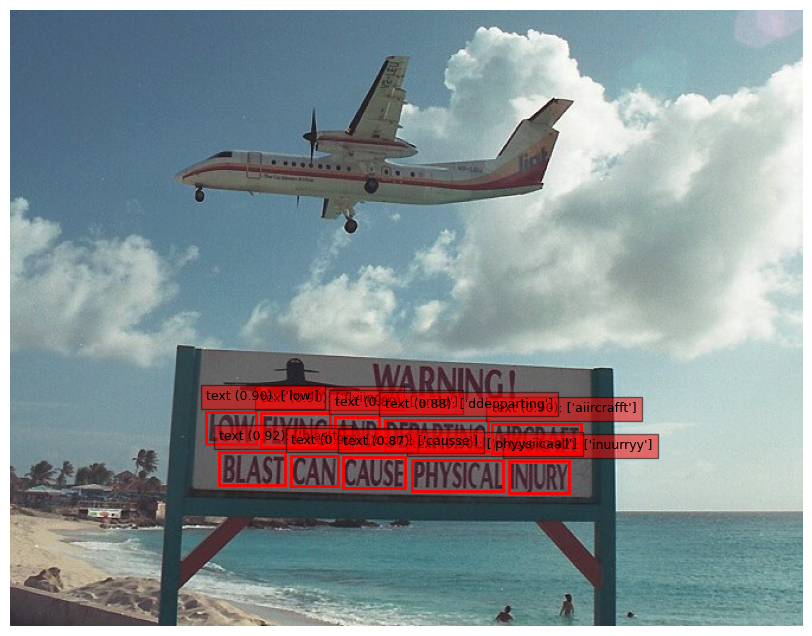

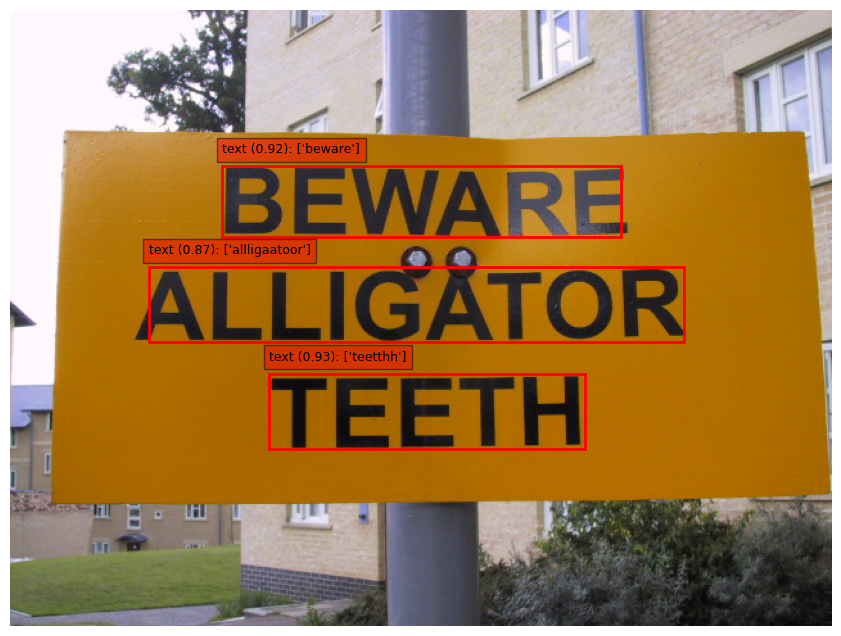

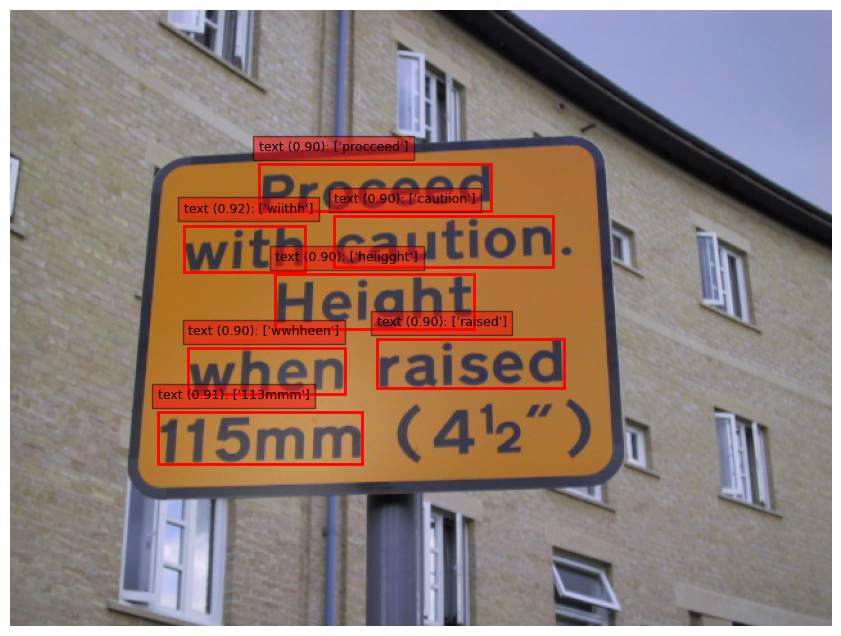

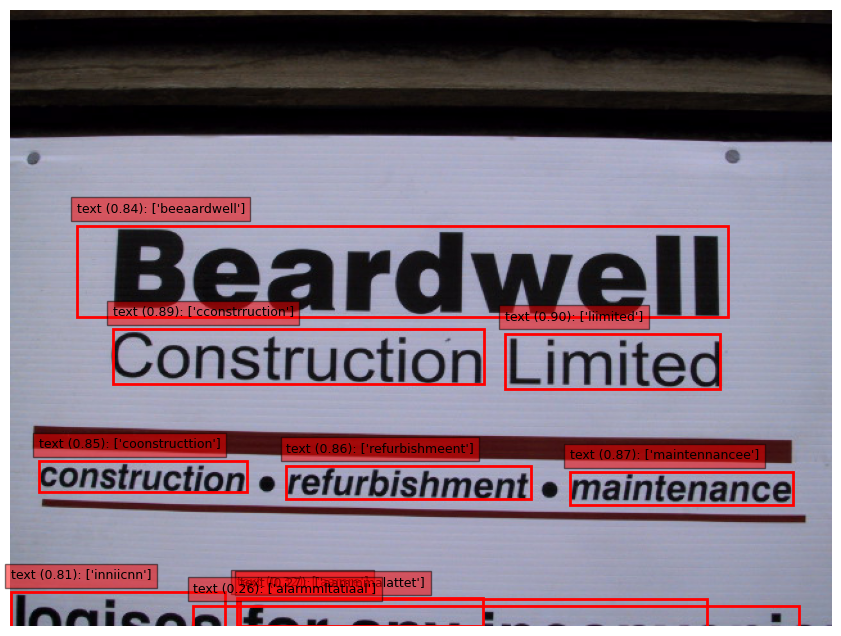

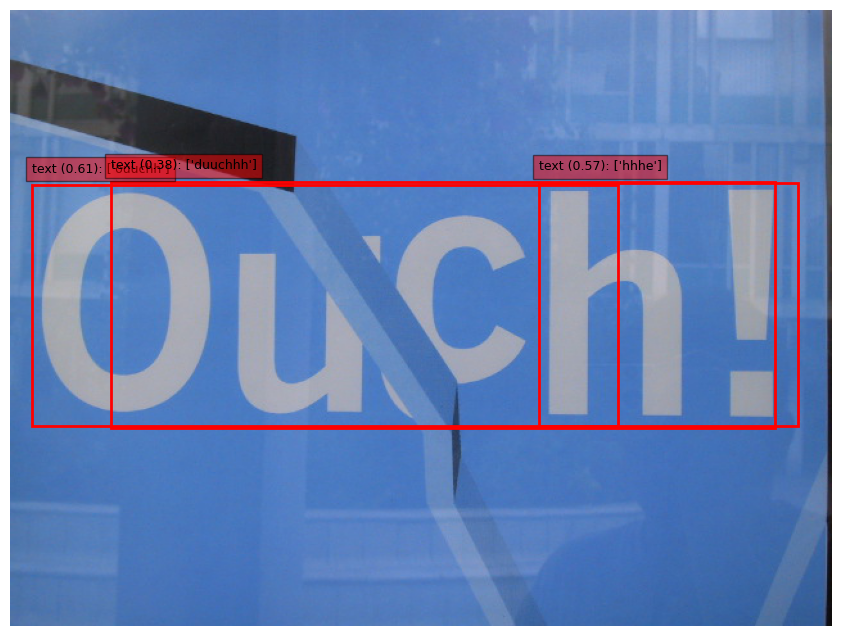

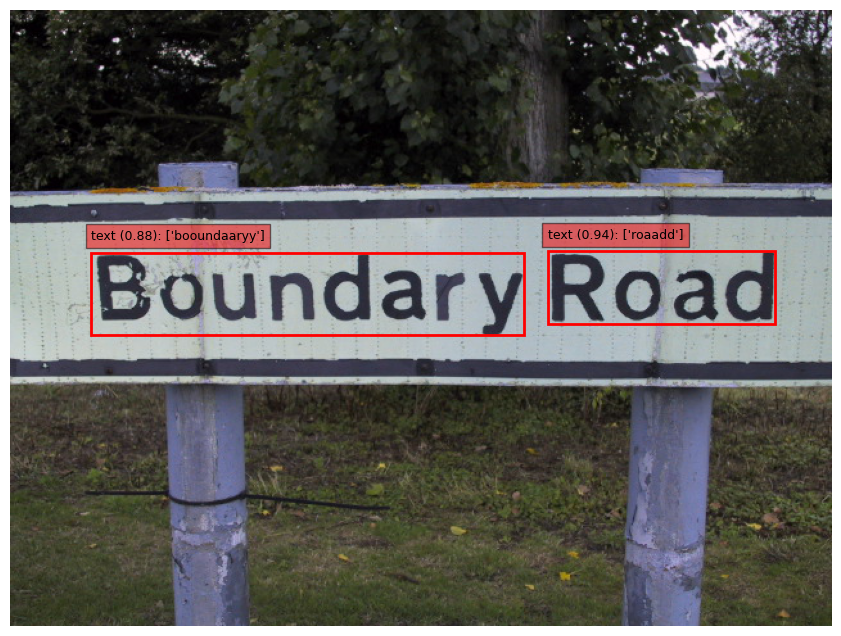

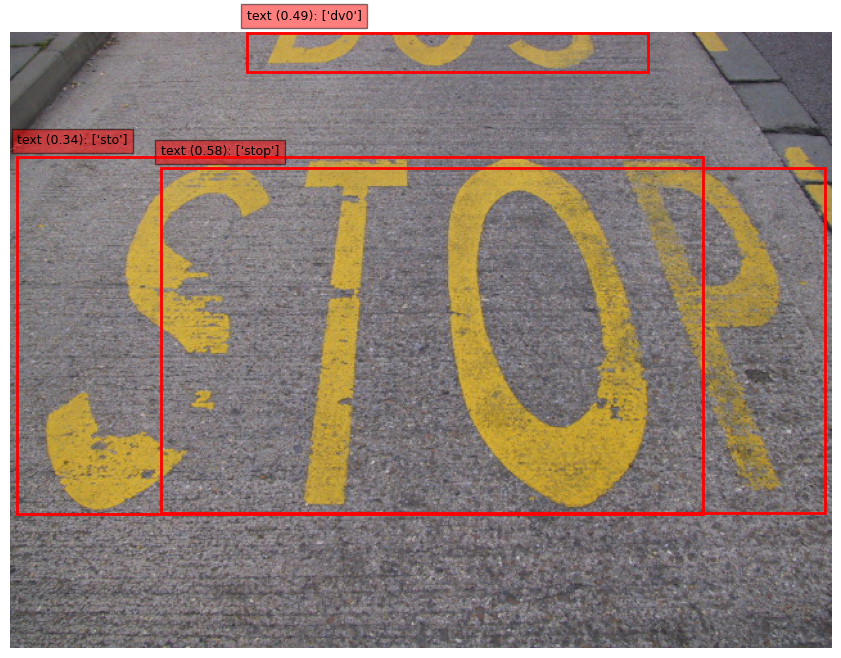

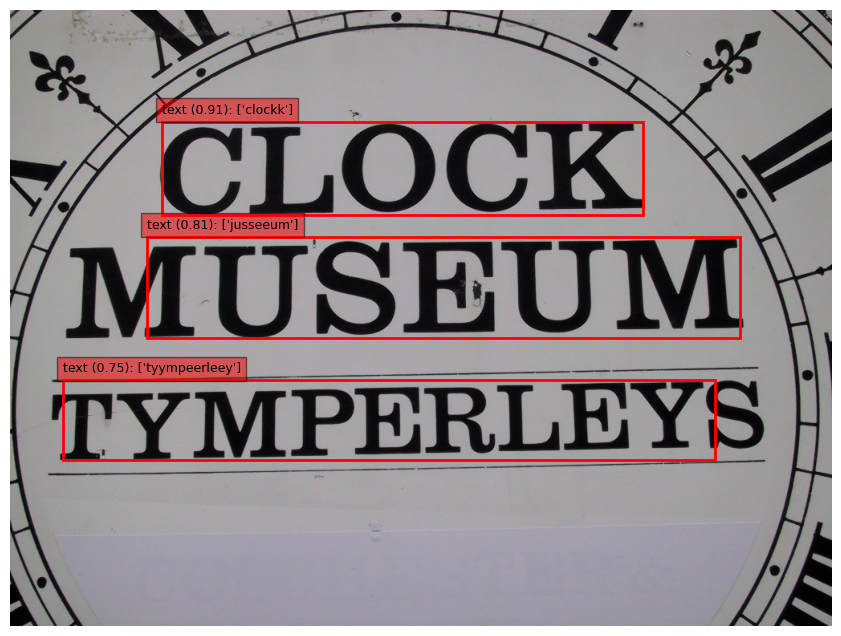

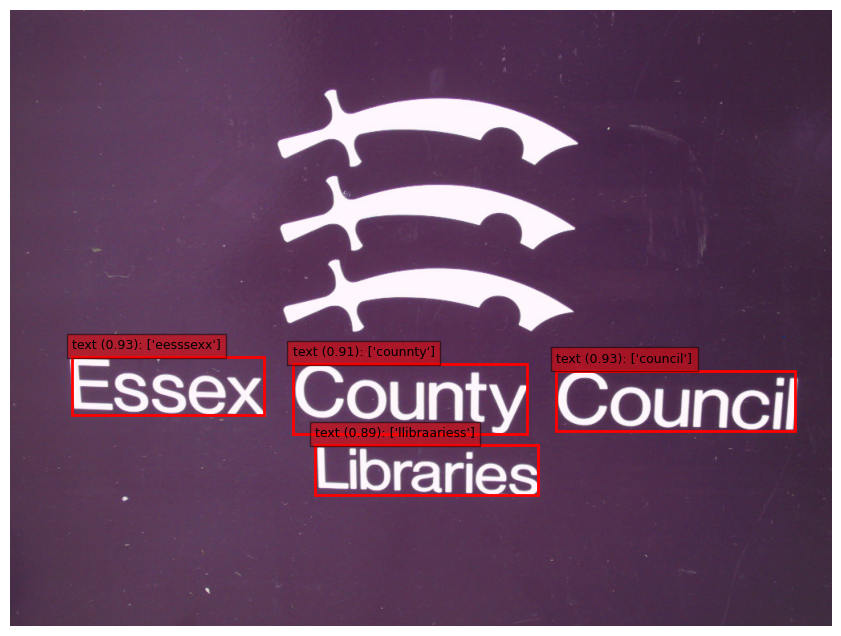

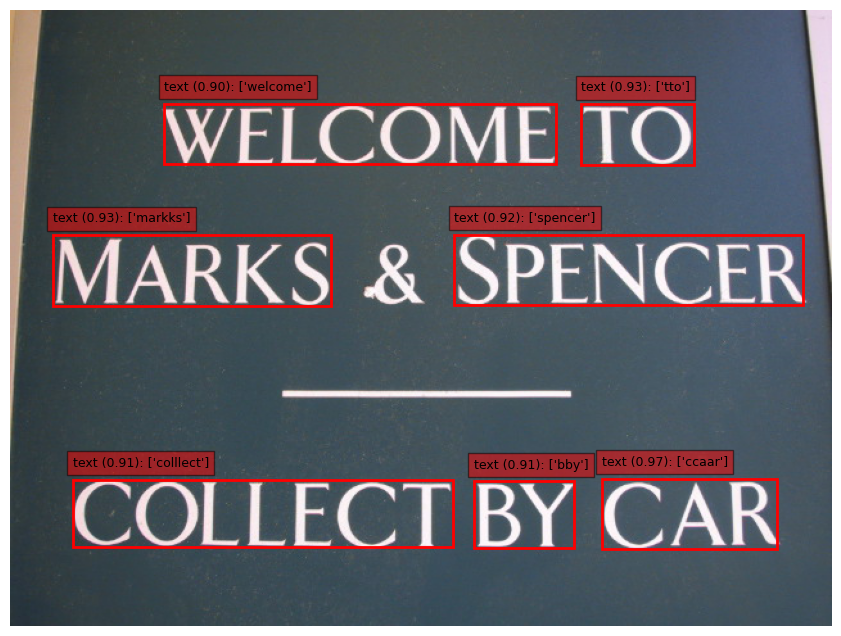

In [14]:
img_dir = 'C:\\Users\\Admin\\AIO\\OCR_STR(Yolov8+CNN)\\icdar2003\\SceneTrialTrain\\lfsosa_12.08.2002'
inf_transforms = data_transforms['val']

for img_filename in os.listdir(img_dir)[:10]:
    img_path = os.path.join(img_dir, img_filename)
    predictions = predict(
        img_path=img_path,
        data_transforms=inf_transforms,
        text_det_model=yolo,
        text_reg_model=crnn_model,
        idx_to_char=idx_to_char,
        device=device,
        visualize=True
    )